In [1]:
import sys
import os
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from tqdm import tqdm
#from SEMPIDataLoader import ListenerSpeakerFeatureDataset
from multimodal_xattention import EarlyFusion, EarlyFusion2, EarlyFusion3

import numpy as np
from types import SimpleNamespace

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

d:\software\Anaconda\envs\eng_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preparing dataset

In [2]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

META_DATA_COLUMNS = ['frame', 'face_id', 'timestamp', 'confidence', 'success']

class ListenerSpeakerFeatureDataset(Dataset):
    def __init__(self, csv_path, frame_length=64, root_dir="", listener_video_features_size=1024, speaker_features_size=1024):
        self.data = pd.read_csv(csv_path)
        self.frame_length = frame_length
        self.root_dir = root_dir
        self.listener_video_features_size = listener_video_features_size  # Fixed size for listener video features
        self.speaker_features_size = speaker_features_size  # Fixed size for speaker features

    def __len__(self):
        return len(self.data)

    def load_audio_feature(self, path):
        full_path = os.path.join(self.root_dir, path)
        try:
            tensor = torch.load(full_path)
            #print(tensor.shape)
            if tensor.ndim == 1:
                tensor = tensor.unsqueeze(0)
            return tensor if tensor.ndim == 2 else tensor
        except Exception as e:
            print(f"Error loading audio feature from {full_path}:\n{e}")
            raise

    def load_openface_feature(self, path, exclude_cols=META_DATA_COLUMNS):
        full_path = os.path.join(self.root_dir, path)
        df = pd.read_csv(full_path)
        df = df.loc[:, ~df.columns.isin(exclude_cols)]
        return torch.tensor(df.values, dtype=torch.float32)

    def load_video_feature(self, path):
        full_path = os.path.join(self.root_dir, path)
        try:
            tensor = torch.load(full_path)
            if tensor.ndim == 1:
                tensor = tensor.unsqueeze(0)
            return tensor.T if tensor.ndim == 2 else tensor
        except Exception as e:
            print(f"Error loading video feature from {full_path}:\n{e}")
            raise

    def _pad_or_crop(self, feature_tensor, expected_size):
        """ Ensure the second dimension (features) is of the expected size """
        _, n_features = feature_tensor.shape
        if n_features < expected_size:
            padding = expected_size - n_features
            feature_tensor = torch.cat([feature_tensor, torch.zeros(feature_tensor.shape[0], padding)], dim=1)
        elif n_features > expected_size:
            feature_tensor = feature_tensor[:, :expected_size]
        return feature_tensor

    def _pad_or_crop_frames(self, feature_tensor):
        """ Padding or cropping the frames dimension to match frame_length """
        n_frames, n_features = feature_tensor.shape
        output = torch.zeros((self.frame_length, n_features))
        if n_frames >= self.frame_length:
            output[:] = feature_tensor[:self.frame_length]
        else:
            output[:n_frames] = feature_tensor
        return output.T

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        #listener_audio = self.load_audio_feature(row["listener_audio_path"])
        listener_video = self.load_video_feature(row["listener_video_path"])
        speaker_audio = self.load_audio_feature(row["speaker_audio_path"])
        #speaker_video = self.load_video_feature(row["speaker_video_path"])
        listener_openface = self.load_openface_feature(row["listener_openface_path"])
        #speaker_openface = self.load_openface_feature(row["speaker_openface_path"])

        listener_video = self._pad_or_crop(listener_video, self.listener_video_features_size)
        listener_video = self._pad_or_crop_frames(listener_video)

        #speaker_video = self._pad_or_crop(speaker_video, self.speaker_features_size)
        #speaker_video = self._pad_or_crop_frames(speaker_video)

        #listener_audio = self._pad_or_crop_frames(listener_audio)
        listener_openface = self._pad_or_crop_frames(listener_openface)

        speaker_audio = self._pad_or_crop_frames(speaker_audio)
        #speaker_openface = self._pad_or_crop_frames(speaker_openface)

        #features = (listener_video, speaker_audio)
        features = (listener_video, listener_openface, speaker_audio)
        #features = (listener_openface, speaker_audio)
        
        engagement = torch.tensor(float(row["engagement"]), dtype=torch.float32)
        pids = torch.tensor([0, 1], dtype=torch.int64)

        return {
            "features": features,
            "score": engagement,
            "pids": pids
        }

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = ListenerSpeakerFeatureDataset(
    csv_path="AudioVideo_Feature_Paths.csv",
    frame_length=64,
    root_dir="./",
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=False)


In [4]:
sample = dataset[0]
listener_video, listener_openface, speaker_audio = sample["features"]
listener_video_dim, listener_facial_dim, speaker_audio_dim = listener_video.shape[0], listener_openface.shape[0], speaker_audio.shape[0]
print(f"Listener video shape: {listener_video.shape}")
print(f"Listener openface shape: {listener_openface.shape}")
print(f"Speaker audio shape: {speaker_audio.shape}")

Listener video shape: torch.Size([1024, 64])
Listener openface shape: torch.Size([329, 64])
Speaker audio shape: torch.Size([768, 64])


# Test 1: Listener Openface + Speaker Speech

In [5]:
config = {
    'ckpt_root': './pretrained',
    'activation_fn': 'tanh',
    'extra_dropout': 0,
    'hidden_size': 128,
    'dropout': 0.1,
    'weight_decay': 0.01,
    'expnum': 8,
    'openfacefeat': 1,
    'openfacefeat_extramlp': 1,
    'openfacefeat_extramlp_dim': 128,
    'ablation': 8,
    'num_labels': 1
}

config = SimpleNamespace(**config)

model = EarlyFusion(config=config).to(device).float()
for name, param in model.named_parameters():
    print(f"Parameter {name}: dtype = {param.dtype}")
print(model)

Parameter extra_mlp.0.weight: dtype = torch.float32
Parameter extra_mlp.0.bias: dtype = torch.float32
Parameter out.fc1.weight: dtype = torch.float32
Parameter out.fc1.bias: dtype = torch.float32
Parameter out.fc2.weight: dtype = torch.float32
Parameter out.fc2.bias: dtype = torch.float32
Parameter out.fc3.weight: dtype = torch.float32
Parameter out.fc3.bias: dtype = torch.float32
Parameter cross_attention.in_proj_weight: dtype = torch.float32
Parameter cross_attention.in_proj_bias: dtype = torch.float32
Parameter cross_attention.out_proj.weight: dtype = torch.float32
Parameter cross_attention.out_proj.bias: dtype = torch.float32
Parameter audio_mlp.0.weight: dtype = torch.float32
Parameter audio_mlp.0.bias: dtype = torch.float32
Parameter fusion_mlp.0.weight: dtype = torch.float32
Parameter fusion_mlp.0.bias: dtype = torch.float32
EarlyFusion(
  (extra_mlp): Sequential(
    (0): Linear(in_features=329, out_features=128, bias=True)
    (1): Tanh()
  )
  (out): Classifier(
    (dropout)

In [6]:
# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Total number of parameters: 272769
Number of trainable parameters: 272769


In [7]:
def compute_ccc_batched(y_pred, y_true):

    y_true_np = y_true.flatten()
    y_pred_np = y_pred.flatten()
    mean_true = np.mean(y_true_np)
    mean_pred = np.mean(y_pred_np)
    std_true = np.std(y_true_np)
    std_pred = np.std(y_pred_np)

    rho, _ = pearsonr(y_true_np, y_pred_np)

    # Calculate CCC
    ccc = (2 * rho * std_true * std_pred) / (std_true**2 + std_pred**2 + (mean_true - mean_pred)**2)
    
    return ccc

import numpy as np
from scipy.stats import pearsonr

def compute_pearson_correlation_batched(y_pred, y_true):
 
    y_true_np = y_true.flatten()
    y_pred_np = y_pred.flatten()

    # Calculate PCC
    rho, _ = pearsonr(y_true_np, y_pred_np)

    return rho

In [8]:
# Training settings
num_epochs = 50
learning_rate = 3e-4
early_stop_patience = 10
best_model_path = 'best_early_fusion_model.pth'

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Training tracking
best_val_ccc = -float('inf')
no_improve_count = 0
train_losses = []
val_losses = []
val_cccs = []
val_pccs = []

d:\software\Anaconda\envs\eng_env\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [9]:
try:
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training:
        model.train()
        total_train_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False):

            _, listener_feat, speaker_feat = batch["features"]
            engagement = batch["score"]
            
            speaker_feat = speaker_feat.to(device).float()
            listener_feat = listener_feat.to(device).float()
            engagement = engagement.to(device)
            engagement = engagement.view(-1, 1)
            optimizer.zero_grad()
            
            # Create a list of listener features with transposed dimensions
            listener_feat_list = []
            for i in range(listener_feat.size(0)):
                listener_feat_list.append(listener_feat[i].transpose(0, 1))
            
            output = model(audio_paths=speaker_feat, openfacefeat_=listener_feat_list)
            loss = criterion(output, engagement)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Training Loss: {avg_train_loss:.4f}")
        
        # Validation:
        model.eval()
        val_loss = 0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False):

                _, listener_feat, speaker_feat = batch["features"]
                engagement = batch["score"]
                
                speaker_feat = speaker_feat.to(device)
                listener_feat = listener_feat.to(device)
                engagement = engagement.to(device)
                engagement = engagement.view(-1, 1)

                # Create a list of listener features with transposed dimensions
                listener_feat_list = []
                for i in range(listener_feat.size(0)):
                    listener_feat_list.append(listener_feat[i].transpose(0, 1))
                
                output = model(audio_paths=speaker_feat, openfacefeat_=listener_feat_list)
                loss = criterion(output, engagement)
                val_loss += loss.item() * engagement.size(0)
                
                # Store predictions and targets for metrics
                val_preds.append(output.cpu())
                val_targets.append(engagement.cpu())
        
        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        # Calculate metrics
        val_preds_combined = torch.cat(val_preds).numpy()
        val_targets_combined = torch.cat(val_targets).numpy()
        
        val_ccc = compute_ccc_batched(val_preds_combined, val_targets_combined)
        val_pcc = compute_pearson_correlation_batched(val_preds_combined, val_targets_combined)
        
        val_cccs.append(val_ccc)
        val_pccs.append(val_pcc)
        
        print(f"Validation Loss: {avg_val_loss:.4f}, CCC: {val_ccc:.4f}, PCC: {val_pcc:.4f}")
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Check if this is the best model
        if val_ccc > best_val_ccc:
            best_val_ccc = val_ccc
            # Save model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
                'val_ccc': val_ccc,
                'val_pcc': val_pcc,
                'config': config,
            }, best_model_path)
            print(f"✓ Saved new best model with validation CCC: {val_ccc:.4f}")

except KeyboardInterrupt:
    print("Training interrupted by user")

Epoch 1/50


Training Loss: 0.0193


Validation Loss: 0.0192, CCC: 0.1747, PCC: 0.3379
✓ Saved new best model with validation CCC: 0.1747
Epoch 2/50


Training Loss: 0.0174


Validation Loss: 0.0157, CCC: 0.1737, PCC: 0.3782
Epoch 3/50


Training Loss: 0.0169


Validation Loss: 0.0165, CCC: 0.2462, PCC: 0.3891
✓ Saved new best model with validation CCC: 0.2462
Epoch 4/50


Training Loss: 0.0164


Validation Loss: 0.0152, CCC: 0.3460, PCC: 0.4113
✓ Saved new best model with validation CCC: 0.3460
Epoch 5/50


Training Loss: 0.0154


Validation Loss: 0.0154, CCC: 0.3010, PCC: 0.4187
Epoch 6/50


Training Loss: 0.0146


Validation Loss: 0.0173, CCC: 0.2870, PCC: 0.3997
Epoch 7/50


Training Loss: 0.0147


Validation Loss: 0.0148, CCC: 0.3416, PCC: 0.4264
Epoch 8/50


Training Loss: 0.0148


Validation Loss: 0.0148, CCC: 0.3160, PCC: 0.4171
Epoch 9/50


Training Loss: 0.0142


Validation Loss: 0.0163, CCC: 0.3343, PCC: 0.4343
Epoch 10/50


Training Loss: 0.0148


Validation Loss: 0.0146, CCC: 0.2995, PCC: 0.4320
Epoch 11/50


Training Loss: 0.0144


Validation Loss: 0.0154, CCC: 0.3663, PCC: 0.4327
✓ Saved new best model with validation CCC: 0.3663
Epoch 12/50


Training Loss: 0.0140


Validation Loss: 0.0152, CCC: 0.3173, PCC: 0.4388
Epoch 13/50


Training Loss: 0.0146


Validation Loss: 0.0149, CCC: 0.3688, PCC: 0.4316
✓ Saved new best model with validation CCC: 0.3688
Epoch 14/50


Training Loss: 0.0140


Validation Loss: 0.0166, CCC: 0.3022, PCC: 0.4440
Epoch 15/50


Training Loss: 0.0137


Validation Loss: 0.0163, CCC: 0.3332, PCC: 0.4300
Epoch 16/50


Training Loss: 0.0133


Validation Loss: 0.0144, CCC: 0.3198, PCC: 0.4552
Epoch 17/50


Training Loss: 0.0139


Validation Loss: 0.0145, CCC: 0.3320, PCC: 0.4487
Epoch 18/50


Training Loss: 0.0139


Validation Loss: 0.0146, CCC: 0.2697, PCC: 0.4374
Epoch 19/50


Training Loss: 0.0130


Validation Loss: 0.0155, CCC: 0.3404, PCC: 0.4277
Epoch 20/50


Training Loss: 0.0132


Validation Loss: 0.0212, CCC: 0.2841, PCC: 0.4082
Epoch 21/50


Training Loss: 0.0134


Validation Loss: 0.0174, CCC: 0.3506, PCC: 0.4304
Epoch 22/50


Training Loss: 0.0128


Validation Loss: 0.0149, CCC: 0.3871, PCC: 0.4422
✓ Saved new best model with validation CCC: 0.3871
Epoch 23/50


Training Loss: 0.0122


Validation Loss: 0.0149, CCC: 0.3971, PCC: 0.4450
✓ Saved new best model with validation CCC: 0.3971
Epoch 24/50


Training Loss: 0.0120


Validation Loss: 0.0149, CCC: 0.3670, PCC: 0.4534
Epoch 25/50


Training Loss: 0.0121


Validation Loss: 0.0157, CCC: 0.3953, PCC: 0.4533
Epoch 26/50


Training Loss: 0.0120


Validation Loss: 0.0150, CCC: 0.4044, PCC: 0.4491
✓ Saved new best model with validation CCC: 0.4044
Epoch 27/50


Training Loss: 0.0118


Validation Loss: 0.0146, CCC: 0.3915, PCC: 0.4601
Epoch 28/50


Training Loss: 0.0118


Validation Loss: 0.0153, CCC: 0.3845, PCC: 0.4593
Epoch 29/50


Training Loss: 0.0114


Validation Loss: 0.0155, CCC: 0.3971, PCC: 0.4514
Epoch 30/50


Training Loss: 0.0114


Validation Loss: 0.0147, CCC: 0.4228, PCC: 0.4632
✓ Saved new best model with validation CCC: 0.4228
Epoch 31/50


Training Loss: 0.0112


Validation Loss: 0.0147, CCC: 0.4124, PCC: 0.4584
Epoch 32/50


Training Loss: 0.0112


Validation Loss: 0.0152, CCC: 0.4154, PCC: 0.4621
Epoch 33/50


Training Loss: 0.0112


Validation Loss: 0.0153, CCC: 0.4261, PCC: 0.4596
✓ Saved new best model with validation CCC: 0.4261
Epoch 34/50


Training Loss: 0.0112


Validation Loss: 0.0154, CCC: 0.4221, PCC: 0.4542
Epoch 35/50


Training Loss: 0.0110


Validation Loss: 0.0148, CCC: 0.4265, PCC: 0.4628
✓ Saved new best model with validation CCC: 0.4265
Epoch 36/50


Training Loss: 0.0108


Validation Loss: 0.0150, CCC: 0.4314, PCC: 0.4617
✓ Saved new best model with validation CCC: 0.4314
Epoch 37/50


Training Loss: 0.0108


Validation Loss: 0.0149, CCC: 0.4328, PCC: 0.4640
✓ Saved new best model with validation CCC: 0.4328
Epoch 38/50


Training Loss: 0.0110


Validation Loss: 0.0155, CCC: 0.4275, PCC: 0.4637
Epoch 39/50


Training Loss: 0.0109


Validation Loss: 0.0147, CCC: 0.4202, PCC: 0.4608
Epoch 40/50


Training Loss: 0.0106


Validation Loss: 0.0149, CCC: 0.4317, PCC: 0.4636
Epoch 41/50


Training Loss: 0.0105


Validation Loss: 0.0152, CCC: 0.4413, PCC: 0.4656
✓ Saved new best model with validation CCC: 0.4413
Epoch 42/50


Training Loss: 0.0105


Validation Loss: 0.0150, CCC: 0.4350, PCC: 0.4647
Epoch 43/50


Training Loss: 0.0106


Validation Loss: 0.0150, CCC: 0.4372, PCC: 0.4661
Epoch 44/50


Training Loss: 0.0105


Validation Loss: 0.0150, CCC: 0.4356, PCC: 0.4657
Epoch 45/50


Training Loss: 0.0106


Validation Loss: 0.0152, CCC: 0.4387, PCC: 0.4662
Epoch 46/50


Training Loss: 0.0106


Validation Loss: 0.0152, CCC: 0.4318, PCC: 0.4653
Epoch 47/50


Training Loss: 0.0104


Validation Loss: 0.0151, CCC: 0.4377, PCC: 0.4654
Epoch 48/50


Training Loss: 0.0104


Validation Loss: 0.0152, CCC: 0.4399, PCC: 0.4665
Epoch 49/50


Training Loss: 0.0104


Validation Loss: 0.0151, CCC: 0.4408, PCC: 0.4661
Epoch 50/50


Training Loss: 0.0104


Validation Loss: 0.0151, CCC: 0.4402, PCC: 0.4663


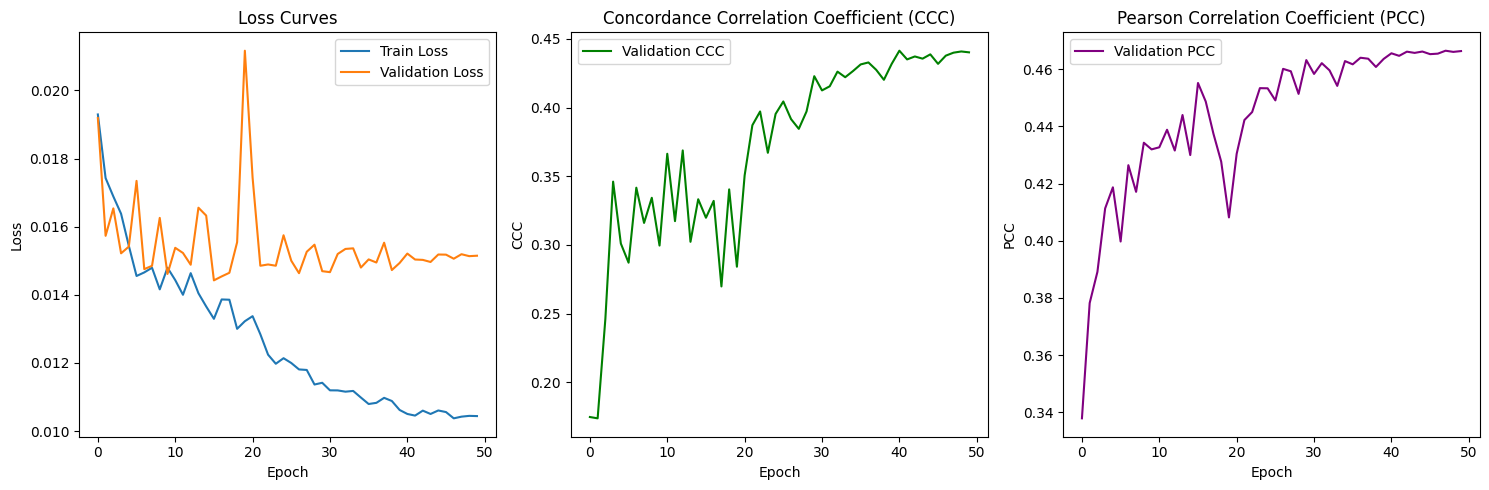

In [10]:
# Final visualization
plt.figure(figsize=(15, 5))

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plot 2: CCC curve
plt.subplot(1, 3, 2)
plt.plot(val_cccs, label='Validation CCC', color='green')
plt.xlabel('Epoch')
plt.ylabel('CCC')
plt.legend()
plt.title('Concordance Correlation Coefficient (CCC)')

# Plot 3: PCC curve
plt.subplot(1, 3, 3)
plt.plot(val_pccs, label='Validation PCC', color='purple')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.legend()
plt.title('Pearson Correlation Coefficient (PCC)')

plt.tight_layout()
plt.savefig('openface_audio.png')
plt.show()

In [11]:
# Load the best model for evaluation
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with:")
    print(f"- Validation Loss: {checkpoint['val_loss']:.4f}")
    print(f"- Validation CCC: {checkpoint['val_ccc']:.4f}")
    print(f"- Validation PCC: {checkpoint['val_pcc']:.4f}")


Loaded best model from epoch 41 with:
- Validation Loss: 0.0152
- Validation CCC: 0.4413
- Validation PCC: 0.4656


# Test 2: Listener Video + Speaker Speech

In [12]:
config = {
    'ckpt_root': './pretrained',
    'activation_fn': 'tanh',
    'extra_dropout': 0,
    'hidden_size': 128,
    'dropout': 0.1,
    'weight_decay': 0.01,
    'expnum': 8,
    'openfacefeat': 1,
    'openfacefeat_extramlp': 1,
    'openfacefeat_extramlp_dim': 128,
    'ablation': 8,
    'num_labels': 1
}

config = SimpleNamespace(**config)

model = EarlyFusion2(config=config).to(device).float()
for name, param in model.named_parameters():
    print(f"Parameter {name}: dtype = {param.dtype}")
print(model)

Parameter out.fc1.weight: dtype = torch.float32
Parameter out.fc1.bias: dtype = torch.float32
Parameter out.fc2.weight: dtype = torch.float32
Parameter out.fc2.bias: dtype = torch.float32
Parameter out.fc3.weight: dtype = torch.float32
Parameter out.fc3.bias: dtype = torch.float32
Parameter cross_attention.in_proj_weight: dtype = torch.float32
Parameter cross_attention.in_proj_bias: dtype = torch.float32
Parameter cross_attention.out_proj.weight: dtype = torch.float32
Parameter cross_attention.out_proj.bias: dtype = torch.float32
Parameter video_mlp.0.weight: dtype = torch.float32
Parameter video_mlp.0.bias: dtype = torch.float32
Parameter audio_mlp.0.weight: dtype = torch.float32
Parameter audio_mlp.0.bias: dtype = torch.float32
Parameter fusion_mlp.0.weight: dtype = torch.float32
Parameter fusion_mlp.0.bias: dtype = torch.float32
EarlyFusion2(
  (out): Classifier(
    (dropout): Dropout(p=0.1, inplace=False)
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (fc2): L

In [13]:
# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Total number of parameters: 361729
Number of trainable parameters: 361729


In [14]:
def compute_ccc_batched(y_pred, y_true):

    y_true_np = y_true.flatten()
    y_pred_np = y_pred.flatten()
    mean_true = np.mean(y_true_np)
    mean_pred = np.mean(y_pred_np)
    std_true = np.std(y_true_np)
    std_pred = np.std(y_pred_np)

    rho, _ = pearsonr(y_true_np, y_pred_np)

    # Calculate CCC
    ccc = (2 * rho * std_true * std_pred) / (std_true**2 + std_pred**2 + (mean_true - mean_pred)**2)
    
    return ccc

import numpy as np
from scipy.stats import pearsonr

def compute_pearson_correlation_batched(y_pred, y_true):
 
    y_true_np = y_true.flatten()
    y_pred_np = y_pred.flatten()

    # Calculate PCC
    rho, _ = pearsonr(y_true_np, y_pred_np)

    return rho

In [15]:
# Training settings
num_epochs = 50
learning_rate = 3e-4
early_stop_patience = 10
best_model_path = 'best_early_fusion_model2.pth'

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Training tracking
best_val_ccc = -float('inf')
no_improve_count = 0
train_losses = []
val_losses = []
val_cccs = []
val_pccs = []

d:\software\Anaconda\envs\eng_env\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [16]:
try:
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training:
        model.train()
        total_train_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False):

            listener_feat, _, speaker_feat = batch["features"]
            engagement = batch["score"]
            
            speaker_feat = speaker_feat.to(device).float()
            listener_feat = listener_feat.to(device).float()
            engagement = engagement.to(device)
            engagement = engagement.view(-1, 1)
            optimizer.zero_grad()
            
            # Create a list of listener features with transposed dimensions
            listener_feat_list = []
            for i in range(listener_feat.size(0)):
                listener_feat_list.append(listener_feat[i].transpose(0, 1))
            
            #output = model(audio_paths=speaker_feat, video_paths=listener_feat_list)
            output = model(audio_paths=speaker_feat, video_paths=listener_feat)
            loss = criterion(output, engagement)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Training Loss: {avg_train_loss:.4f}")
        
        # Validation:
        model.eval()
        val_loss = 0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False):

                listener_feat, _, speaker_feat = batch["features"]
                engagement = batch["score"]
                
                speaker_feat = speaker_feat.to(device)
                listener_feat = listener_feat.to(device)
                engagement = engagement.to(device)
                engagement = engagement.view(-1, 1)

                # Create a list of listener features with transposed dimensions
                listener_feat_list = []
                for i in range(listener_feat.size(0)):
                    listener_feat_list.append(listener_feat[i].transpose(0, 1))
                
                #output = model(audio_paths=speaker_feat, video_paths=listener_feat_list)
                output = model(audio_paths=speaker_feat, video_paths=listener_feat)
                loss = criterion(output, engagement)
                val_loss += loss.item() * engagement.size(0)
                
                # Store predictions and targets for metrics
                val_preds.append(output.cpu())
                val_targets.append(engagement.cpu())
        
        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        # Calculate metrics
        val_preds_combined = torch.cat(val_preds).numpy()
        val_targets_combined = torch.cat(val_targets).numpy()
        
        val_ccc = compute_ccc_batched(val_preds_combined, val_targets_combined)
        val_pcc = compute_pearson_correlation_batched(val_preds_combined, val_targets_combined)
        
        val_cccs.append(val_ccc)
        val_pccs.append(val_pcc)
        
        print(f"Validation Loss: {avg_val_loss:.4f}, CCC: {val_ccc:.4f}, PCC: {val_pcc:.4f}")
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Check if this is the best model
        if val_ccc > best_val_ccc:
            best_val_ccc = val_ccc
            # Save model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
                'val_ccc': val_ccc,
                'val_pcc': val_pcc,
                'config': config,
            }, best_model_path)
            print(f"✓ Saved new best model with validation CCC: {val_ccc:.4f}")

except KeyboardInterrupt:
    print("Training interrupted by user")

Epoch 1/50


Training Loss: 0.0185


Validation Loss: 0.0167, CCC: 0.1231, PCC: 0.2836
✓ Saved new best model with validation CCC: 0.1231
Epoch 2/50


Training Loss: 0.0172


Validation Loss: 0.0164, CCC: 0.1926, PCC: 0.2962
✓ Saved new best model with validation CCC: 0.1926
Epoch 3/50


Training Loss: 0.0169


Validation Loss: 0.0165, CCC: 0.2347, PCC: 0.3636
✓ Saved new best model with validation CCC: 0.2347
Epoch 4/50


Training Loss: 0.0159


Validation Loss: 0.0157, CCC: 0.2497, PCC: 0.3559
✓ Saved new best model with validation CCC: 0.2497
Epoch 5/50


Training Loss: 0.0157


Validation Loss: 0.0162, CCC: 0.2766, PCC: 0.3490
✓ Saved new best model with validation CCC: 0.2766
Epoch 6/50


Training Loss: 0.0157


Validation Loss: 0.0167, CCC: 0.3184, PCC: 0.3623
✓ Saved new best model with validation CCC: 0.3184
Epoch 7/50


Training Loss: 0.0154


Validation Loss: 0.0156, CCC: 0.2283, PCC: 0.3699
Epoch 8/50


Training Loss: 0.0149


Validation Loss: 0.0176, CCC: 0.2690, PCC: 0.3604
Epoch 9/50


Training Loss: 0.0152


Validation Loss: 0.0159, CCC: 0.2686, PCC: 0.3551
Epoch 10/50


Training Loss: 0.0148


Validation Loss: 0.0156, CCC: 0.2435, PCC: 0.3645
Epoch 11/50


Training Loss: 0.0147


Validation Loss: 0.0157, CCC: 0.3093, PCC: 0.3797
Epoch 12/50


Training Loss: 0.0146


Validation Loss: 0.0164, CCC: 0.3047, PCC: 0.3715
Epoch 13/50


Training Loss: 0.0144


Validation Loss: 0.0159, CCC: 0.3164, PCC: 0.3774
Epoch 14/50


Training Loss: 0.0142


Validation Loss: 0.0162, CCC: 0.2383, PCC: 0.3654
Epoch 15/50


Training Loss: 0.0144


Validation Loss: 0.0156, CCC: 0.2712, PCC: 0.3727
Epoch 16/50


Training Loss: 0.0145


Validation Loss: 0.0152, CCC: 0.2350, PCC: 0.3928
Epoch 17/50


Training Loss: 0.0142


Validation Loss: 0.0167, CCC: 0.3222, PCC: 0.3619
✓ Saved new best model with validation CCC: 0.3222
Epoch 18/50


Training Loss: 0.0139


Validation Loss: 0.0163, CCC: 0.3147, PCC: 0.3650
Epoch 19/50


Training Loss: 0.0142


Validation Loss: 0.0162, CCC: 0.3072, PCC: 0.3700
Epoch 20/50


Training Loss: 0.0138


Validation Loss: 0.0168, CCC: 0.3195, PCC: 0.3596
Epoch 21/50


Training Loss: 0.0139


Validation Loss: 0.0154, CCC: 0.2969, PCC: 0.3833
Epoch 22/50


Training Loss: 0.0138


Validation Loss: 0.0164, CCC: 0.3279, PCC: 0.3864
✓ Saved new best model with validation CCC: 0.3279
Epoch 23/50


Training Loss: 0.0134


Validation Loss: 0.0170, CCC: 0.3359, PCC: 0.3713
✓ Saved new best model with validation CCC: 0.3359
Epoch 24/50


Training Loss: 0.0132


Validation Loss: 0.0163, CCC: 0.3313, PCC: 0.3775
Epoch 25/50


Training Loss: 0.0133


Validation Loss: 0.0166, CCC: 0.3266, PCC: 0.3751
Epoch 26/50


Training Loss: 0.0132


Validation Loss: 0.0166, CCC: 0.3254, PCC: 0.3659
Epoch 27/50


Training Loss: 0.0131


Validation Loss: 0.0169, CCC: 0.3279, PCC: 0.3705
Epoch 28/50


Training Loss: 0.0131


Validation Loss: 0.0165, CCC: 0.3332, PCC: 0.3751
Epoch 29/50


Training Loss: 0.0128


Validation Loss: 0.0164, CCC: 0.3318, PCC: 0.3773
Epoch 30/50


Training Loss: 0.0128


Validation Loss: 0.0165, CCC: 0.3252, PCC: 0.3779
Epoch 31/50


Training Loss: 0.0127


Validation Loss: 0.0170, CCC: 0.3438, PCC: 0.3733
✓ Saved new best model with validation CCC: 0.3438
Epoch 32/50


Training Loss: 0.0128


Validation Loss: 0.0169, CCC: 0.3420, PCC: 0.3760
Epoch 33/50


Training Loss: 0.0126


Validation Loss: 0.0167, CCC: 0.3352, PCC: 0.3759
Epoch 34/50


Training Loss: 0.0127


Validation Loss: 0.0166, CCC: 0.3329, PCC: 0.3715
Epoch 35/50


Training Loss: 0.0125


Validation Loss: 0.0169, CCC: 0.3360, PCC: 0.3745
Epoch 36/50


Training Loss: 0.0125


Validation Loss: 0.0166, CCC: 0.3364, PCC: 0.3740
Epoch 37/50


Training Loss: 0.0125


Validation Loss: 0.0168, CCC: 0.3431, PCC: 0.3756
Epoch 38/50


Training Loss: 0.0124


Validation Loss: 0.0168, CCC: 0.3423, PCC: 0.3744
Epoch 39/50


Training Loss: 0.0125


Validation Loss: 0.0169, CCC: 0.3388, PCC: 0.3748
Epoch 40/50


Training Loss: 0.0125


Validation Loss: 0.0167, CCC: 0.3401, PCC: 0.3742
Epoch 41/50


Training Loss: 0.0123


Validation Loss: 0.0168, CCC: 0.3418, PCC: 0.3743
Epoch 42/50


Training Loss: 0.0124


Validation Loss: 0.0167, CCC: 0.3399, PCC: 0.3749
Epoch 43/50


Training Loss: 0.0123


Validation Loss: 0.0169, CCC: 0.3443, PCC: 0.3741
✓ Saved new best model with validation CCC: 0.3443
Epoch 44/50


Training Loss: 0.0123


Validation Loss: 0.0170, CCC: 0.3397, PCC: 0.3744
Epoch 45/50


Training Loss: 0.0123


Validation Loss: 0.0169, CCC: 0.3401, PCC: 0.3735
Epoch 46/50


Training Loss: 0.0123


Validation Loss: 0.0169, CCC: 0.3410, PCC: 0.3741
Epoch 47/50


Training Loss: 0.0122


Validation Loss: 0.0168, CCC: 0.3415, PCC: 0.3735
Epoch 48/50


Training Loss: 0.0122


Validation Loss: 0.0170, CCC: 0.3426, PCC: 0.3736
Epoch 49/50


Training Loss: 0.0122


Validation Loss: 0.0169, CCC: 0.3418, PCC: 0.3732
Epoch 50/50


Training Loss: 0.0121


Validation Loss: 0.0169, CCC: 0.3434, PCC: 0.3734


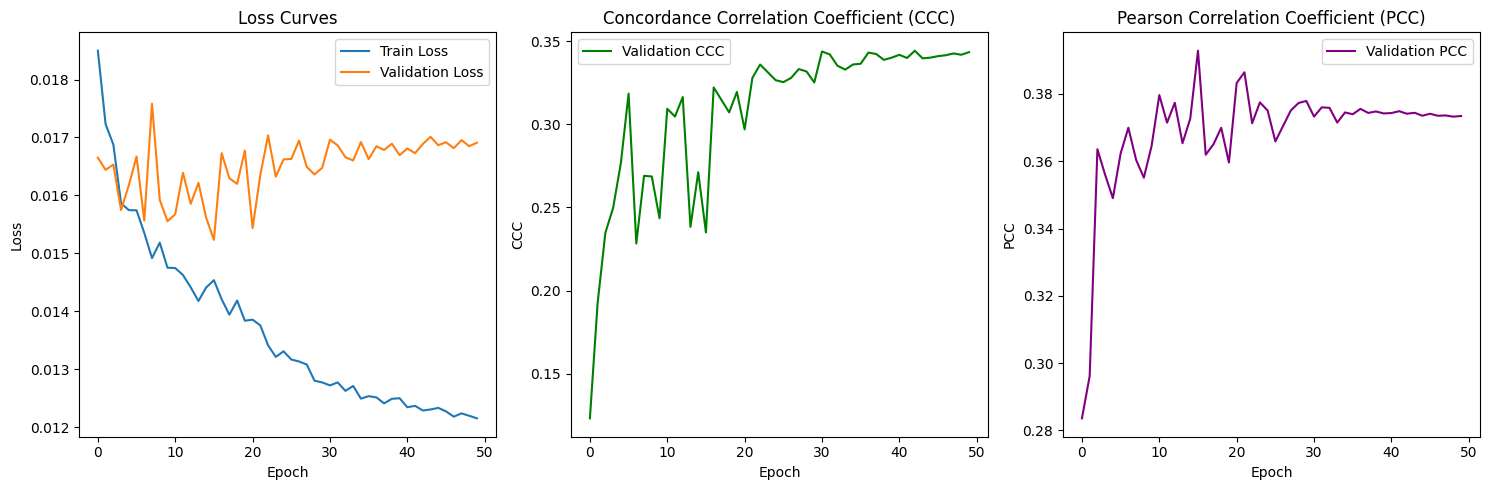

In [17]:
# Final visualization
plt.figure(figsize=(15, 5))

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plot 2: CCC curve
plt.subplot(1, 3, 2)
plt.plot(val_cccs, label='Validation CCC', color='green')
plt.xlabel('Epoch')
plt.ylabel('CCC')
plt.legend()
plt.title('Concordance Correlation Coefficient (CCC)')

# Plot 3: PCC curve
plt.subplot(1, 3, 3)
plt.plot(val_pccs, label='Validation PCC', color='purple')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.legend()
plt.title('Pearson Correlation Coefficient (PCC)')

plt.tight_layout()
plt.savefig('video_audio.png')
plt.show()

In [18]:
# Load the best model for evaluation
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with:")
    print(f"- Validation Loss: {checkpoint['val_loss']:.4f}")
    print(f"- Validation CCC: {checkpoint['val_ccc']:.4f}")
    print(f"- Validation PCC: {checkpoint['val_pcc']:.4f}")


Loaded best model from epoch 43 with:
- Validation Loss: 0.0169
- Validation CCC: 0.3443
- Validation PCC: 0.3741


# Test 3: Listener Openface + Listener Video + Speaker Speech

In [19]:
config = {
    'ckpt_root': './pretrained',
    'activation_fn': 'tanh',
    'extra_dropout': 0,
    'hidden_size': 128,
    'dropout': 0.1,
    'weight_decay': 0.01,
    'expnum': 8,
    'openfacefeat': 1,
    'openfacefeat_extramlp': 1,
    'openfacefeat_extramlp_dim': 128,
    'ablation': 8,
    'num_labels': 1
}

config = SimpleNamespace(**config)

model = EarlyFusion3(config=config).to(device).float()
for name, param in model.named_parameters():
    print(f"Parameter {name}: dtype = {param.dtype}")
print(model)

Parameter extra_mlp.0.weight: dtype = torch.float32
Parameter extra_mlp.0.bias: dtype = torch.float32
Parameter out.fc1.weight: dtype = torch.float32
Parameter out.fc1.bias: dtype = torch.float32
Parameter out.fc2.weight: dtype = torch.float32
Parameter out.fc2.bias: dtype = torch.float32
Parameter out.fc3.weight: dtype = torch.float32
Parameter out.fc3.bias: dtype = torch.float32
Parameter cross_attention.in_proj_weight: dtype = torch.float32
Parameter cross_attention.in_proj_bias: dtype = torch.float32
Parameter cross_attention.out_proj.weight: dtype = torch.float32
Parameter cross_attention.out_proj.bias: dtype = torch.float32
Parameter video_mlp.0.weight: dtype = torch.float32
Parameter video_mlp.0.bias: dtype = torch.float32
Parameter audio_mlp.0.weight: dtype = torch.float32
Parameter audio_mlp.0.bias: dtype = torch.float32
Parameter fusion_mlp.0.weight: dtype = torch.float32
Parameter fusion_mlp.0.bias: dtype = torch.float32
Parameter fusion_mlp2.0.weight: dtype = torch.float32


In [20]:
# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Total number of parameters: 453249
Number of trainable parameters: 453249


In [21]:
def compute_ccc_batched(y_pred, y_true):

    y_true_np = y_true.flatten()
    y_pred_np = y_pred.flatten()
    mean_true = np.mean(y_true_np)
    mean_pred = np.mean(y_pred_np)
    std_true = np.std(y_true_np)
    std_pred = np.std(y_pred_np)

    rho, _ = pearsonr(y_true_np, y_pred_np)

    # Calculate CCC
    ccc = (2 * rho * std_true * std_pred) / (std_true**2 + std_pred**2 + (mean_true - mean_pred)**2)
    
    return ccc

import numpy as np
from scipy.stats import pearsonr

def compute_pearson_correlation_batched(y_pred, y_true):
 
    y_true_np = y_true.flatten()
    y_pred_np = y_pred.flatten()

    # Calculate PCC
    rho, _ = pearsonr(y_true_np, y_pred_np)

    return rho

In [22]:
# Training settings
num_epochs = 50
learning_rate = 3e-4
early_stop_patience = 10
best_model_path = 'best_early_fusion_model3.pth'

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Training tracking
best_val_ccc = -float('inf')
no_improve_count = 0
train_losses = []
val_losses = []
val_cccs = []
val_pccs = []

d:\software\Anaconda\envs\eng_env\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [23]:
try:
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training:
        model.train()
        total_train_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False):

            listener_video_feat, listener_facial_feat, speaker_audio_feat = batch["features"]
            engagement = batch["score"]
            
            listener_video_feat = listener_video_feat.to(device).float()
            listener_facial_feat = listener_facial_feat.to(device).float()
            speaker_audio_feat = speaker_audio_feat.to(device).float()
            
            engagement = engagement.to(device)
            engagement = engagement.view(-1, 1)
            optimizer.zero_grad()
            
            # Create a list of listener features with transposed dimensions
            listener_facial_list = []
            for i in range(listener_facial_feat.size(0)):
                listener_facial_list.append(listener_facial_feat[i].transpose(0, 1))
            
            output = model(audio_paths=speaker_audio_feat, openfacefeat_=listener_facial_list, video_paths=listener_video_feat)
            loss = criterion(output, engagement)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Training Loss: {avg_train_loss:.4f}")
        
        # Validation:
        model.eval()
        val_loss = 0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False):

                listener_video_feat, listener_facial_feat, speaker_audio_feat = batch["features"]
                engagement = batch["score"]
                
                listener_video_feat = listener_video_feat.to(device)
                listener_facial_feat = listener_facial_feat.to(device)
                speaker_audio_feat = speaker_audio_feat.to(device)
                engagement = engagement.to(device)
                engagement = engagement.view(-1, 1)

                # Create a list of listener features with transposed dimensions
                listener_facial_list = []
                for i in range(listener_facial_feat.size(0)):
                    listener_facial_list.append(listener_facial_feat[i].transpose(0, 1))
                
                output = model(audio_paths=speaker_audio_feat, openfacefeat_=listener_facial_list, video_paths=listener_video_feat)
                loss = criterion(output, engagement)
                val_loss += loss.item() * engagement.size(0)
                
                # Store predictions and targets for metrics
                val_preds.append(output.cpu())
                val_targets.append(engagement.cpu())
        
        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        # Calculate metrics
        val_preds_combined = torch.cat(val_preds).numpy()
        val_targets_combined = torch.cat(val_targets).numpy()
        
        val_ccc = compute_ccc_batched(val_preds_combined, val_targets_combined)
        val_pcc = compute_pearson_correlation_batched(val_preds_combined, val_targets_combined)
        
        val_cccs.append(val_ccc)
        val_pccs.append(val_pcc)
        
        print(f"Validation Loss: {avg_val_loss:.4f}, CCC: {val_ccc:.4f}, PCC: {val_pcc:.4f}")
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Check if this is the best model
        if val_ccc > best_val_ccc:
            best_val_ccc = val_ccc
            # Save model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
                'val_ccc': val_ccc,
                'val_pcc': val_pcc,
                'config': config,
            }, best_model_path)
            print(f"✓ Saved new best model with validation CCC: {val_ccc:.4f}")

except KeyboardInterrupt:
    print("Training interrupted by user")

Epoch 1/50


Training Loss: 0.0195


Validation Loss: 0.0166, CCC: 0.1515, PCC: 0.2965
✓ Saved new best model with validation CCC: 0.1515
Epoch 2/50


Training Loss: 0.0177


Validation Loss: 0.0157, CCC: 0.1798, PCC: 0.3671
✓ Saved new best model with validation CCC: 0.1798
Epoch 3/50


Training Loss: 0.0164


Validation Loss: 0.0170, CCC: 0.2660, PCC: 0.3915
✓ Saved new best model with validation CCC: 0.2660
Epoch 4/50


Training Loss: 0.0161


Validation Loss: 0.0155, CCC: 0.2696, PCC: 0.3729
✓ Saved new best model with validation CCC: 0.2696
Epoch 5/50


Training Loss: 0.0154


Validation Loss: 0.0157, CCC: 0.3412, PCC: 0.4085
✓ Saved new best model with validation CCC: 0.3412
Epoch 6/50


Training Loss: 0.0151


Validation Loss: 0.0155, CCC: 0.2792, PCC: 0.4160
Epoch 7/50


Training Loss: 0.0148


Validation Loss: 0.0146, CCC: 0.3496, PCC: 0.4379
✓ Saved new best model with validation CCC: 0.3496
Epoch 8/50


Training Loss: 0.0143


Validation Loss: 0.0148, CCC: 0.3552, PCC: 0.4355
✓ Saved new best model with validation CCC: 0.3552
Epoch 9/50


Training Loss: 0.0144


Validation Loss: 0.0149, CCC: 0.3554, PCC: 0.4286
✓ Saved new best model with validation CCC: 0.3554
Epoch 10/50


Training Loss: 0.0146


Validation Loss: 0.0151, CCC: 0.2734, PCC: 0.4055
Epoch 11/50


Training Loss: 0.0142


Validation Loss: 0.0150, CCC: 0.2416, PCC: 0.4204
Epoch 12/50


Training Loss: 0.0141


Validation Loss: 0.0150, CCC: 0.3436, PCC: 0.4469
Epoch 13/50


Training Loss: 0.0139


Validation Loss: 0.0166, CCC: 0.2632, PCC: 0.4063
Epoch 14/50


Training Loss: 0.0131


Validation Loss: 0.0146, CCC: 0.3920, PCC: 0.4491
✓ Saved new best model with validation CCC: 0.3920
Epoch 15/50


Training Loss: 0.0127


Validation Loss: 0.0149, CCC: 0.3896, PCC: 0.4448
Epoch 16/50


Training Loss: 0.0129


Validation Loss: 0.0143, CCC: 0.3580, PCC: 0.4492
Epoch 17/50


Training Loss: 0.0126


Validation Loss: 0.0151, CCC: 0.4092, PCC: 0.4517
✓ Saved new best model with validation CCC: 0.4092
Epoch 18/50


Training Loss: 0.0128


Validation Loss: 0.0145, CCC: 0.4026, PCC: 0.4594
Epoch 19/50


Training Loss: 0.0124


Validation Loss: 0.0162, CCC: 0.3605, PCC: 0.4475
Epoch 20/50


Training Loss: 0.0123


Validation Loss: 0.0172, CCC: 0.3603, PCC: 0.4548
Epoch 21/50


Training Loss: 0.0125


Validation Loss: 0.0153, CCC: 0.4104, PCC: 0.4488
✓ Saved new best model with validation CCC: 0.4104
Epoch 22/50


Training Loss: 0.0123


Validation Loss: 0.0161, CCC: 0.3950, PCC: 0.4537
Epoch 23/50


Training Loss: 0.0118


Validation Loss: 0.0149, CCC: 0.4166, PCC: 0.4552
✓ Saved new best model with validation CCC: 0.4166
Epoch 24/50


Training Loss: 0.0118


Validation Loss: 0.0154, CCC: 0.3923, PCC: 0.4550
Epoch 25/50


Training Loss: 0.0117


Validation Loss: 0.0150, CCC: 0.4083, PCC: 0.4510
Epoch 26/50


Training Loss: 0.0117


Validation Loss: 0.0150, CCC: 0.4039, PCC: 0.4500
Epoch 27/50


Training Loss: 0.0118


Validation Loss: 0.0154, CCC: 0.3972, PCC: 0.4551
Epoch 28/50


Training Loss: 0.0117


Validation Loss: 0.0148, CCC: 0.4060, PCC: 0.4520
Epoch 29/50


Training Loss: 0.0112


Validation Loss: 0.0154, CCC: 0.4212, PCC: 0.4576
✓ Saved new best model with validation CCC: 0.4212
Epoch 30/50


Training Loss: 0.0112


Validation Loss: 0.0150, CCC: 0.4228, PCC: 0.4559
✓ Saved new best model with validation CCC: 0.4228
Epoch 31/50


Training Loss: 0.0111


Validation Loss: 0.0152, CCC: 0.4188, PCC: 0.4597
Epoch 32/50


Training Loss: 0.0112


Validation Loss: 0.0148, CCC: 0.4156, PCC: 0.4622
Epoch 33/50


Training Loss: 0.0114


Validation Loss: 0.0159, CCC: 0.4072, PCC: 0.4578
Epoch 34/50


Training Loss: 0.0112


Validation Loss: 0.0152, CCC: 0.4142, PCC: 0.4630
Epoch 35/50


Training Loss: 0.0109


Validation Loss: 0.0151, CCC: 0.4219, PCC: 0.4602
Epoch 36/50


Training Loss: 0.0110


Validation Loss: 0.0154, CCC: 0.4262, PCC: 0.4624
✓ Saved new best model with validation CCC: 0.4262
Epoch 37/50


Training Loss: 0.0110


Validation Loss: 0.0149, CCC: 0.4240, PCC: 0.4599
Epoch 38/50


Training Loss: 0.0108


Validation Loss: 0.0151, CCC: 0.4323, PCC: 0.4619
✓ Saved new best model with validation CCC: 0.4323
Epoch 39/50


Training Loss: 0.0109


Validation Loss: 0.0151, CCC: 0.4241, PCC: 0.4605
Epoch 40/50


Training Loss: 0.0108


Validation Loss: 0.0151, CCC: 0.4275, PCC: 0.4607
Epoch 41/50


Training Loss: 0.0108


Validation Loss: 0.0150, CCC: 0.4296, PCC: 0.4613
Epoch 42/50


Training Loss: 0.0106


Validation Loss: 0.0152, CCC: 0.4300, PCC: 0.4619
Epoch 43/50


Training Loss: 0.0107


Validation Loss: 0.0151, CCC: 0.4334, PCC: 0.4619
✓ Saved new best model with validation CCC: 0.4334
Epoch 44/50


Training Loss: 0.0106


Validation Loss: 0.0152, CCC: 0.4342, PCC: 0.4629
✓ Saved new best model with validation CCC: 0.4342
Epoch 45/50


Training Loss: 0.0107


Validation Loss: 0.0154, CCC: 0.4284, PCC: 0.4628
Epoch 46/50


Training Loss: 0.0106


Validation Loss: 0.0151, CCC: 0.4359, PCC: 0.4633
✓ Saved new best model with validation CCC: 0.4359
Epoch 47/50


Training Loss: 0.0106


Validation Loss: 0.0151, CCC: 0.4355, PCC: 0.4636
Epoch 48/50


Training Loss: 0.0105


Validation Loss: 0.0152, CCC: 0.4346, PCC: 0.4634
Epoch 49/50


Training Loss: 0.0107


Validation Loss: 0.0152, CCC: 0.4327, PCC: 0.4636
Epoch 50/50


Training Loss: 0.0105


Validation Loss: 0.0152, CCC: 0.4324, PCC: 0.4636


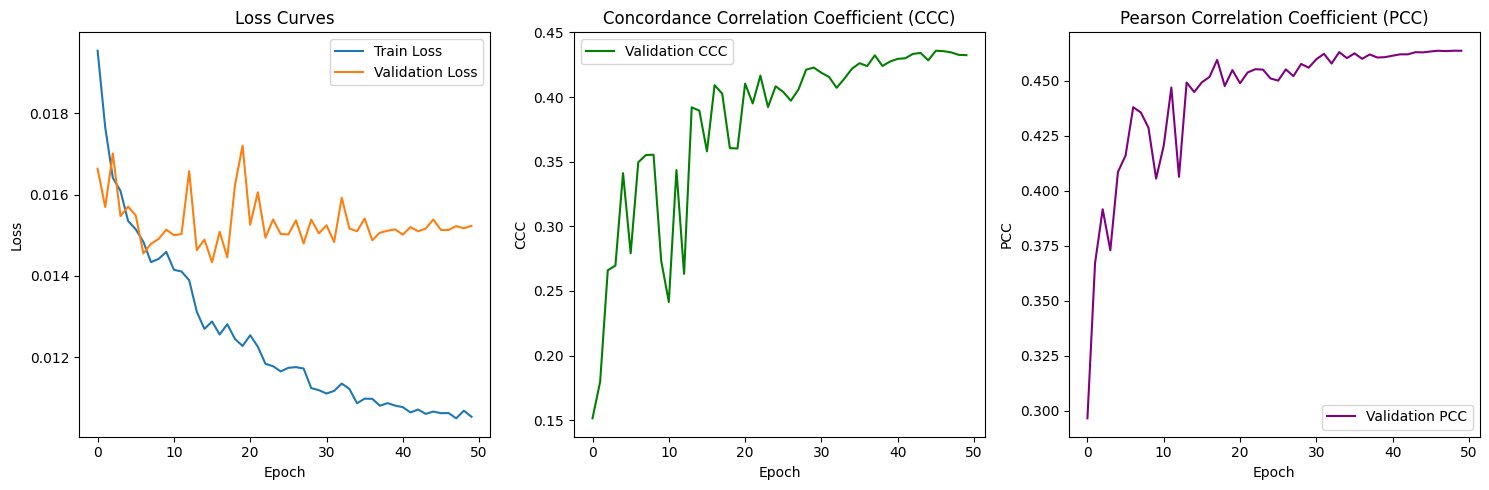

In [24]:
# Final visualization
plt.figure(figsize=(15, 5))

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plot 2: CCC curve
plt.subplot(1, 3, 2)
plt.plot(val_cccs, label='Validation CCC', color='green')
plt.xlabel('Epoch')
plt.ylabel('CCC')
plt.legend()
plt.title('Concordance Correlation Coefficient (CCC)')

# Plot 3: PCC curve
plt.subplot(1, 3, 3)
plt.plot(val_pccs, label='Validation PCC', color='purple')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.legend()
plt.title('Pearson Correlation Coefficient (PCC)')

plt.tight_layout()
plt.savefig('video_openface_audio.png')
plt.show()

In [25]:
# Load the best model for evaluation
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with:")
    print(f"- Validation Loss: {checkpoint['val_loss']:.4f}")
    print(f"- Validation CCC: {checkpoint['val_ccc']:.4f}")
    print(f"- Validation PCC: {checkpoint['val_pcc']:.4f}")


Loaded best model from epoch 46 with:
- Validation Loss: 0.0151
- Validation CCC: 0.4359
- Validation PCC: 0.4633
